In [1]:
# Step 1: Import Required Libraries

import cv2  # OpenCV for video and image processing
import numpy as np  # For working with arrays
import matplotlib.pyplot as plt  # For visualizing frames
import os  # For file path handling
from datetime import timedelta  # For converting frame index to time

# Display plots inline in the Jupyter notebook
%matplotlib inline

# Ensure output folders exist for saving results
os.makedirs("OutputFrames", exist_ok=True)
os.makedirs("OutputVideos", exist_ok=True)
os.makedirs("AlertLogs", exist_ok=True)

print("✅ Libraries loaded and output folders ready.")

✅ Libraries loaded and output folders ready.


In [2]:
# Step 2: Define Helper Functions

def get_video_properties(video_path):
    """
    Get properties like total frames, frame rate, and frame dimensions from a video.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Frame width
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Frame height
    cap.release()
    return total_frames, fps, width, height


def convert_frame_to_time(frame_number, fps):
    """
    Convert frame number to timestamp in hh:mm:ss format.
    """
    seconds = frame_number / fps
    return str(timedelta(seconds=seconds))


def detect_red_intensity(frame):
    """
    Detect red intensity in a frame by creating a mask in HSV color space.
    Returns both the red masked frame and a measure of red pixel ratio.
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Red spans two HSV ranges
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    combined_mask = cv2.bitwise_or(mask1, mask2)
    
    red_detected = cv2.bitwise_and(frame, frame, mask=combined_mask)
    
    # Red intensity as percentage of pixels
    red_pixel_ratio = np.sum(combined_mask > 0) / (frame.shape[0] * frame.shape[1])
    
    return red_detected, red_pixel_ratio


In [3]:
# Step 3: Set input video path and prepare output settings

# Set your input video path here
input_video_path = "InputVideos/input_thermal_video.mp4"  # Change the file name if needed

# Extract base name to align output filenames
import os
video_basename = os.path.splitext(os.path.basename(input_video_path))[0]

# Create folders for outputs (if not already present)
os.makedirs("OutputVideos", exist_ok=True)
os.makedirs("OutputFrames", exist_ok=True)

# Output video path
output_video_path = f"OutputVideos/{video_basename}_red_detection_output.mp4"

# Get video properties
total_frames, fps, width, height = get_video_properties(input_video_path)

# Initialize the VideoWriter to save the processed output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
out_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Print video properties for reference
print(f"Input Video: {input_video_path}")
print(f"Total Frames: {total_frames}")
print(f"FPS: {fps}")
print(f"Resolution: {width} x {height}")
print(f"Output Video: {output_video_path}")

Input Video: InputVideos/input_thermal_video.mp4
Total Frames: 0
FPS: 0.0
Resolution: 0 x 0
Output Video: OutputVideos/input_thermal_video_red_detection_output.mp4


In [4]:
# Step 4: Loop through video frames and detect red zones with time-based alert

# Open the input video
cap = cv2.VideoCapture(input_video_path)

frame_count = 0                    # Counter to track current frame number
alert_triggered = False           # Flag to track if red intensity has increased
red_alert_log = []                # List to store alert timestamps
previous_red_intensity = 0        # Store red intensity of previous frame

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Convert frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define lower and upper ranges for red in HSV (covering both ends of the hue spectrum)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for both red ranges and combine them
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Apply the red mask to the original frame
    red_result = cv2.bitwise_and(frame, frame, mask=red_mask)

    # Calculate red intensity as number of red pixels
    red_intensity = cv2.countNonZero(red_mask)

    # Get current timestamp (in seconds) based on FPS
    timestamp = frame_count / fps

    # Check if red intensity increases significantly from previous frame
    if red_intensity > previous_red_intensity * 1.5 and red_intensity > 5000:  # Customize threshold
        alert_triggered = True
        red_alert_log.append((frame_count, timestamp, red_intensity))
        alert_text = f"⚠️ Alert: Red Increasing at {timestamp:.2f}s"
        color = (0, 0, 255)  # Red
    else:
        alert_text = f"Time: {timestamp:.2f}s"
        color = (255, 255, 255)  # White

    previous_red_intensity = red_intensity

    # Overlay the alert or time on the frame
    cv2.putText(red_result, alert_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Save the processed frame as an image (optional)
    output_frame_path = f"OutputFrames/{video_basename}_frame_{frame_count:04d}.jpg"
    cv2.imwrite(output_frame_path, red_result)

    # Write the frame to output video
    out_writer.write(red_result)

    # Show live preview (optional for debugging)
    # cv2.imshow("Red Detection", red_result)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

    frame_count += 1  # Move to next frame

# Release resources
cap.release()
out_writer.release()
cv2.destroyAllWindows()

print("✅ Video processing complete!")


✅ Video processing complete!


In [5]:
# Step 5 : Process video frames, detect red zones, save output video with alerts, and log times
import cv2 # OpenCV for video and image processing
import os

def process_video_and_save_output(input_video_path):
    # Extract base filename without extension for output naming
    base_name = os.path.splitext(os.path.basename(input_video_path))[0]

    # Create output folder if it doesn't exist
    output_folder = "OutputVideos"
    os.makedirs(output_folder, exist_ok=True)

    # Define output video path with base name + suffix, use .avi extension for better compatibility
    output_video_path = os.path.join(output_folder, f"{base_name}_red_detection_output.avi")

    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {input_video_path}")
        return

    # Get video properties for output writer
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))    # Frame width
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Frame height
    fps = cap.get(cv2.CAP_PROP_FPS)                    # Frames per second
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing video: {input_video_path}")
    print(f"Resolution: {width}x{height}, FPS: {fps}, Total frames: {total_frames}")

    # Define codec and create VideoWriter object (XVID codec for better Windows compatibility)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    alert_log = []  # To store alert info: frame number, timestamp, intensity

    frame_index = 0
    alert_triggered = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Convert frame to HSV color space for color detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red1 = (0, 50, 50)
        upper_red1 = (10, 255, 255)
        lower_red2 = (160, 50, 50)
        upper_red2 = (180, 255, 255)

        # Create masks for red ranges
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)

        # Calculate red intensity as the number of red pixels detected
        red_intensity = cv2.countNonZero(red_mask)

        # Apply mask to frame to show detected red zones
        red_zone_frame = cv2.bitwise_and(frame, frame, mask=red_mask)

        # Overlay the red zone mask on the original frame for visualization
        # Blend original frame with red zones highlighted (red tint)
        overlay = frame.copy()
        overlay[red_mask > 0] = (0, 0, 255)  # Highlight red pixels in pure red color (BGR)

        output_frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)

        # Check if red intensity crosses threshold (adjust threshold as needed)
        threshold = 5000
        if red_intensity > threshold and not alert_triggered:
            alert_triggered = True
            # Calculate timestamp in seconds
            timestamp = frame_index / fps
            alert_log.append({
                "frame": frame_index,
                "timestamp_sec": timestamp,
                "red_intensity": red_intensity,
                "message": "Alert: Red intensity increasing"
            })

            # Put alert text on the output frame
            alert_text = f"Alert: Red intensity increasing at {timestamp:.2f} sec"
            cv2.putText(output_frame, alert_text, (30, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

        # Write processed frame to output video
        out.write(output_frame)

        # Optional: Show the frame (comment out if running in batch)
        # cv2.imshow("Red Detection", output_frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

        frame_index += 1

    # Release resources
    cap.release()
    out.release()
    # cv2.destroyAllWindows()

    print(f"Processing complete. Output saved to: {output_video_path}")
    print("Alert Log:")
    for entry in alert_log:
        print(entry)

    return alert_log, output_video_path


In [6]:
#Step 5.1: Process video and extract red intensity alerts
input_video_path = r"Thermal Video/video1.mp4"  # Change to your input video path

# Process the video, generate output video with red detection overlays and alerts
alert_log, output_video = process_video_and_save_output(input_video_path)

Processing video: Thermal Video/video1.mp4
Resolution: 640x480, FPS: 30.0, Total frames: 600
Processing complete. Output saved to: OutputVideos\video1_red_detection_output.avi
Alert Log:
{'frame': 0, 'timestamp_sec': 0.0, 'red_intensity': 42373, 'message': 'Alert: Red intensity increasing'}


In [7]:
# Step 6: Display a specific frame to visually inspect red zone detection

import cv2
import numpy as np
import os
from datetime import timedelta

# Function to process video, detect red zones, save output video with detection,
# and log alert data when red intensity crosses threshold
def detect_red_zones_in_video(input_video_path, output_folder="OutputVideos", alert_threshold=5000):
    # Extract base filename without extension for output naming
    base_name = os.path.splitext(os.path.basename(input_video_path))[0]
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file: {input_video_path}")
        return []
    
    # Get video properties for output video
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
    
    output_video_path = os.path.join(output_folder, f"{base_name}_red_detection_output.mp4")
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    frame_index = 0
    alert_log = []  # To keep track of alerts with frame number, intensity and timestamp
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print(f"End of video or cannot read frame number {frame_index}. Stopping.")
            break
        
        # Convert frame to HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Define red color ranges in HSV
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 50, 50])
        upper_red2 = np.array([180, 255, 255])
        
        # Create masks for red color ranges
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)
        
        # Calculate red intensity as number of red pixels
        red_intensity = cv2.countNonZero(mask)
        
        # Apply mask to original frame to highlight red zones
        red_zone = cv2.bitwise_and(frame, frame, mask=mask)
        
        # Overlay the red detection on original frame for visualization
        overlay = frame.copy()
        overlay[mask > 0] = [0, 0, 255]  # Mark detected red areas in pure red color (BGR)
        alpha = 0.5
        output_frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        
        # Check if red intensity crosses alert threshold
        if red_intensity > alert_threshold:
            # Calculate timestamp in seconds and formatted string
            timestamp_sec = frame_index / fps
            timestamp_str = str(timedelta(seconds=timestamp_sec)).split(".")[0]  # hh:mm:ss format
            
            alert_msg = f"Alert! Increasing red intensity at frame {frame_index}, time {timestamp_str}, intensity {red_intensity}"
            print(alert_msg)
            
            # Draw alert message text on video frame
            cv2.putText(output_frame, alert_msg, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, (0, 0, 255), 2, cv2.LINE_AA)
            
            # Log the alert details
            alert_log.append({
                "frame": frame_index,
                "red_intensity": red_intensity,
                "timestamp_sec": timestamp_sec,
                "timestamp_str": timestamp_str
            })
        
        # Write the processed frame to output video
        out.write(output_frame)
        
        frame_index += 1
    
    # Release video objects
    cap.release()
    out.release()
    
    print(f"Processing completed. Output video saved at: {output_video_path}")
    
    return alert_log


In [8]:
# Step 6.1: Call the function to process the video and detect red zones
alert_log = detect_red_zones_in_video(r"Thermal Video\video1.mp4")

Alert! Increasing red intensity at frame 0, time 0:00:00, intensity 42373
Alert! Increasing red intensity at frame 1, time 0:00:00, intensity 42270
Alert! Increasing red intensity at frame 2, time 0:00:00, intensity 42261
Alert! Increasing red intensity at frame 3, time 0:00:00, intensity 42282
Alert! Increasing red intensity at frame 4, time 0:00:00, intensity 42406
Alert! Increasing red intensity at frame 5, time 0:00:00, intensity 42401
Alert! Increasing red intensity at frame 6, time 0:00:00, intensity 42399
Alert! Increasing red intensity at frame 7, time 0:00:00, intensity 42406
Alert! Increasing red intensity at frame 8, time 0:00:00, intensity 42612
Alert! Increasing red intensity at frame 9, time 0:00:00, intensity 42632
Alert! Increasing red intensity at frame 10, time 0:00:00, intensity 42613
Alert! Increasing red intensity at frame 11, time 0:00:00, intensity 42613
Alert! Increasing red intensity at frame 12, time 0:00:00, intensity 42919
Alert! Increasing red intensity at 

In [9]:
#step 6.2: Save specific frames as images for inspection
# Function to save specific frames as images for inspection
import cv2
import os

def save_frame_images(input_video_path, output_video_path, frame_number, save_folder="OutputFrames"):
    os.makedirs(save_folder, exist_ok=True)
    
    cap_orig = cv2.VideoCapture(input_video_path)
    cap_processed = cv2.VideoCapture(output_video_path)
    
    # Set frame position
    cap_orig.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    cap_processed.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret_orig, frame_orig = cap_orig.read()
    ret_proc, frame_proc = cap_processed.read()
    
    if not ret_orig or not ret_proc:
        print(f"Could not read frame {frame_number}")
        return
    
    # Save original frame
    orig_path = os.path.join(save_folder, f"frame_{frame_number:04d}_original.jpg")
    cv2.imwrite(orig_path, frame_orig)
    
    # Save processed frame
    proc_path = os.path.join(save_folder, f"frame_{frame_number:04d}_red_detected.jpg")
    cv2.imwrite(proc_path, frame_proc)
    
    print(f"Saved original frame to: {orig_path}")
    print(f"Saved processed frame to: {proc_path}")
    
    cap_orig.release()
    cap_processed.release()


In [10]:
# step 6.3: Call the function to save specific frames
# Example: Save frame number 150 from both original and processed videos
input_video = "Thermal Video/video1.mp4"
processed_video = "OutputVideos/video1_red_detection_output.mp4"
frame_to_save = 150  # Example frame number

save_frame_images(input_video, processed_video, frame_to_save)


Saved original frame to: OutputFrames\frame_0150_original.jpg
Saved processed frame to: OutputFrames\frame_0150_red_detected.jpg


In [11]:
# Step 7: Plot red pixel intensity over time and highlight frames where intensity is high

import matplotlib.pyplot as plt

# Assuming alert_log is the output from detect_red_zones_in_video function
# You must have run Step 6 first and saved the alert_log like:
# alert_log = detect_red_zones_in_video('path_to_your_video.mp4')

def plot_red_intensity(alert_log, alert_threshold=5000, fps=30):
    if not alert_log:
        print("No alerts detected, nothing to plot.")
        return
    
    # Extract data for plotting
    frame_indices = [entry['frame'] for entry in alert_log]
    red_intensities = [entry['red_intensity'] for entry in alert_log]
    timestamps_sec = [entry['timestamp_sec'] for entry in alert_log]
    
    plt.figure(figsize=(14, 7))
    plt.plot(frame_indices, red_intensities, label='Red Intensity (Pixel Count)', marker='o')
    plt.axhline(y=alert_threshold, color='r', linestyle='--', label='Alert Threshold')
    
    # Annotate each alert point with timestamp (seconds)
    for frame, intensity, ts in zip(frame_indices, red_intensities, timestamps_sec):
        plt.text(frame, intensity + 2000, f"{ts:.1f}s", fontsize=9, color='red', rotation=45)
    
    plt.title("Red Intensity in Video Frames with Alert Timestamps")
    plt.xlabel("Frame Number")
    plt.ylabel("Red Pixel Count")
    plt.legend()
    plt.grid(True)
    plt.show()


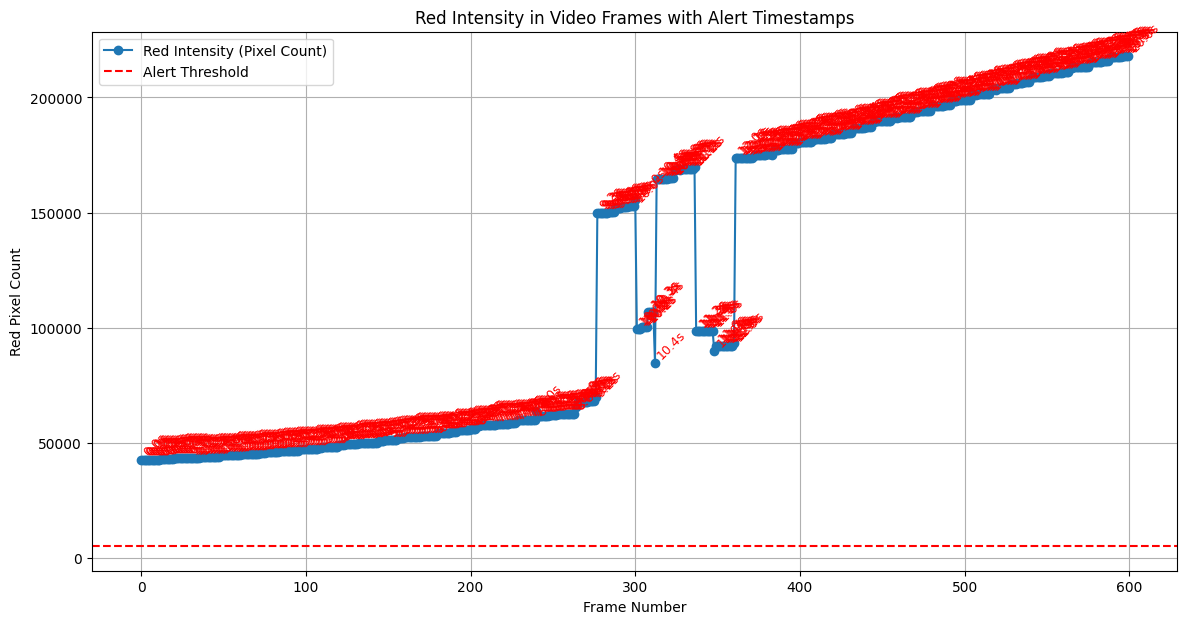

In [12]:
#step 7.1: Call the function to plot red intensity over time
# Plot red intensity over time with alert threshold
plot_red_intensity(alert_log, alert_threshold=5000, fps=30)  # fps should match your video fps


In [13]:
#Step 7.2: Heatmap of Red Intensity per Second
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_red_intensity_heatmap(alert_log, total_frames, fps):
    red_intensity_array = np.zeros(total_frames)
    for entry in alert_log:
        red_intensity_array[entry['frame']] = entry['red_intensity']
    
    heatmap_data = red_intensity_array.reshape(-1, int(fps))  # one row per second
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="Reds", cbar=True)
    plt.title("Heatmap of Red Intensity per Second")
    plt.xlabel("Frame Index within Second")
    plt.ylabel("Second")
    plt.show()


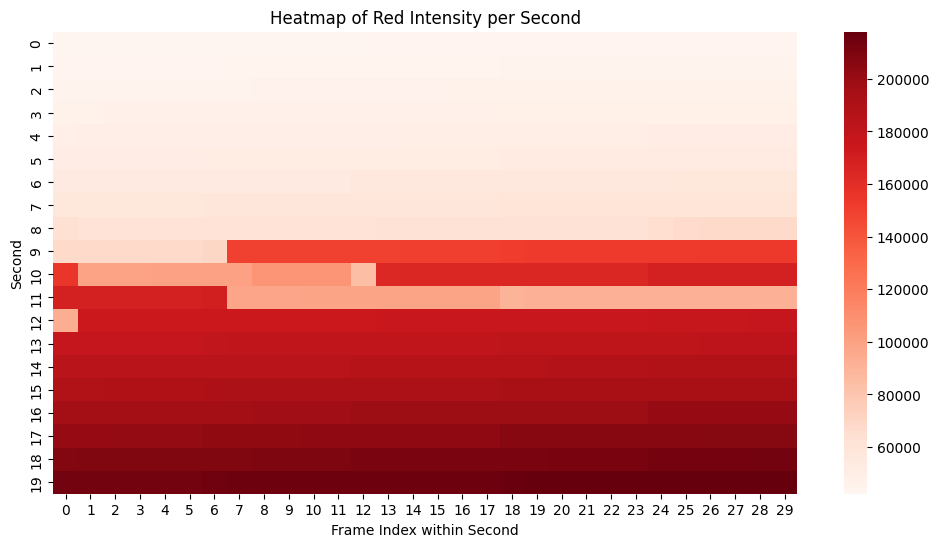

In [14]:
total_frames = int(cv2.VideoCapture("Thermal Video/video1.mp4").get(cv2.CAP_PROP_FRAME_COUNT))
fps = 30  # Set according to your video
plot_red_intensity_heatmap(alert_log, total_frames, fps)


In [15]:
# Step 7.3: Histogram of Red Pixel Intensity Distribution
def plot_red_intensity_histogram(alert_log):
    intensities = [entry['red_intensity'] for entry in alert_log]
    plt.figure(figsize=(10, 5))
    plt.hist(intensities, bins=20, color='red', edgecolor='black')
    plt.title("Distribution of Red Pixel Intensities")
    plt.xlabel("Red Pixel Count")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


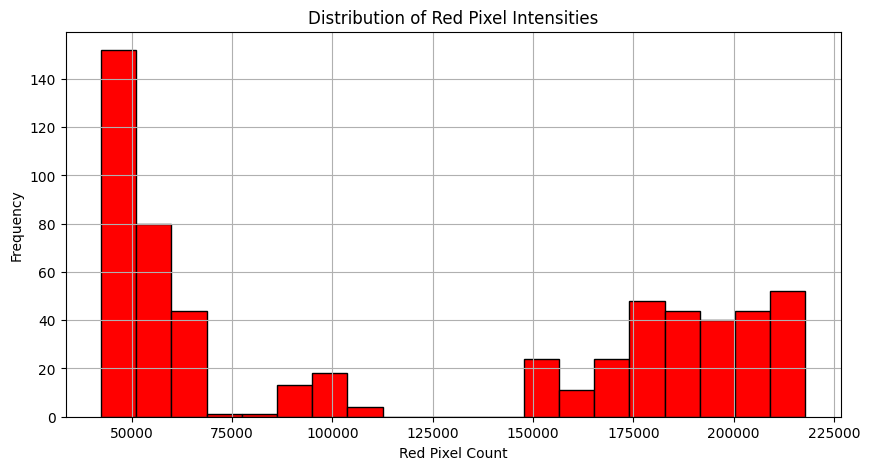

In [16]:
plot_red_intensity_histogram(alert_log)


In [17]:
#Step 7.4: Summary Table of Top Alert Frames
import pandas as pd

def display_alert_summary_table(alert_log, top_n=10, min_threshold=5000):
    filtered = [entry for entry in alert_log if entry['red_intensity'] >= min_threshold]
    top_alerts = sorted(filtered, key=lambda x: x['red_intensity'], reverse=True)[:top_n]
    df = pd.DataFrame(top_alerts)
    display(df[['frame', 'timestamp_str', 'red_intensity']])


In [18]:
display_alert_summary_table(alert_log, top_n=10, min_threshold=5000)


frame timestamp_str  red_intensity
0    597       0:00:19         217910
1    598       0:00:19         217910
2    599       0:00:19         217910
3    596       0:00:19         217901
4    593       0:00:19         217771
5    594       0:00:19         217771
6    595       0:00:19         217771
7    592       0:00:19         217763
8    589       0:00:19         217681
9    591       0:00:19         217671

In [19]:
#Step 7.5: Combined Summary Execution (Optional Wrapper)
def generate_red_alert_summary(alert_log, input_video_path, fps=30, top_n=10, threshold=5000):
    total_frames = int(cv2.VideoCapture(input_video_path).get(cv2.CAP_PROP_FRAME_COUNT))
    
    print("📊 Summary Table of Top Alert Frames:")
    display_alert_summary_table(alert_log, top_n=top_n, min_threshold=threshold)

    print("\n📉 Plotting Red Intensity Over Time:")
    plot_red_intensity(alert_log, alert_threshold=threshold, fps=fps)

    print("\n🔥 Plotting Red Intensity Heatmap:")
    plot_red_intensity_heatmap(alert_log, total_frames=total_frames, fps=fps)

    print("\n📈 Plotting Red Intensity Histogram:")
    plot_red_intensity_histogram(alert_log)


📊 Summary Table of Top Alert Frames:


frame timestamp_str  red_intensity
0    597       0:00:19         217910
1    598       0:00:19         217910
2    599       0:00:19         217910
3    596       0:00:19         217901
4    593       0:00:19         217771
5    594       0:00:19         217771
6    595       0:00:19         217771
7    592       0:00:19         217763
8    589       0:00:19         217681
9    591       0:00:19         217671


📉 Plotting Red Intensity Over Time:


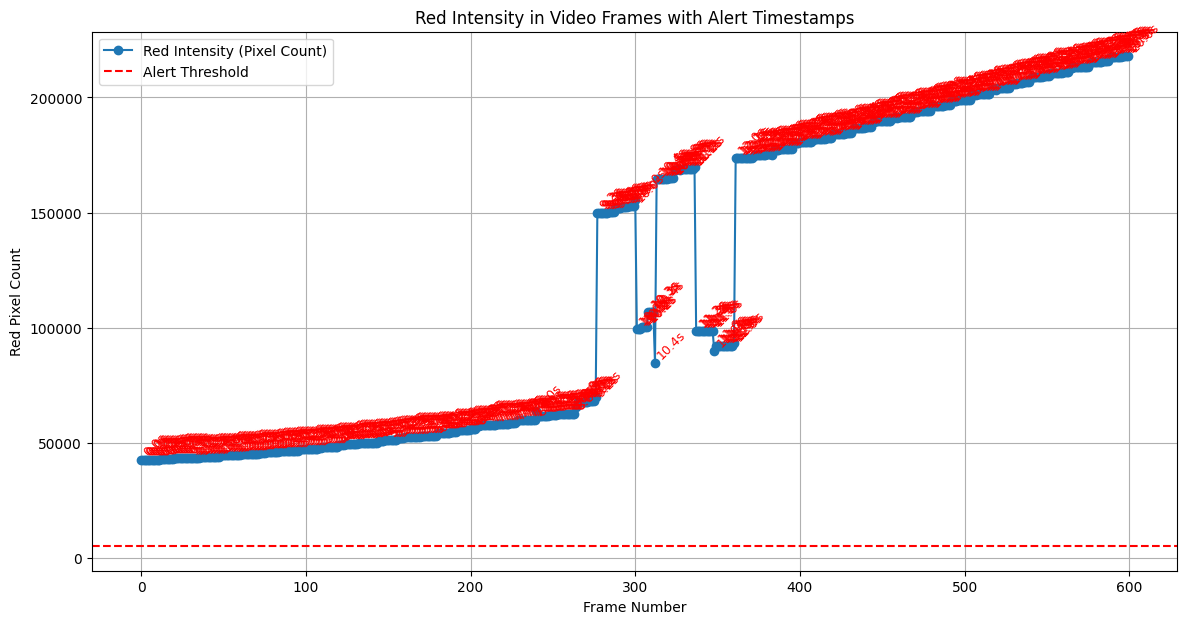


🔥 Plotting Red Intensity Heatmap:


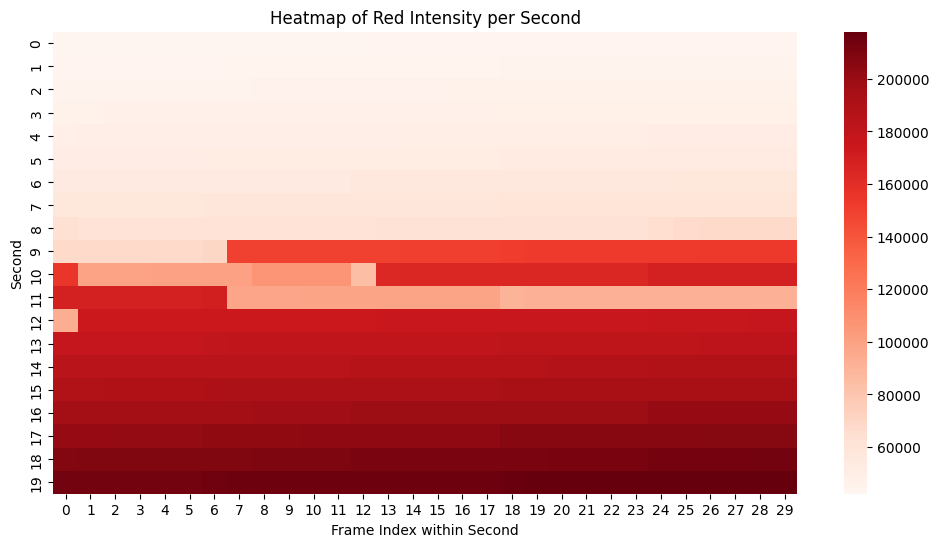


📈 Plotting Red Intensity Histogram:


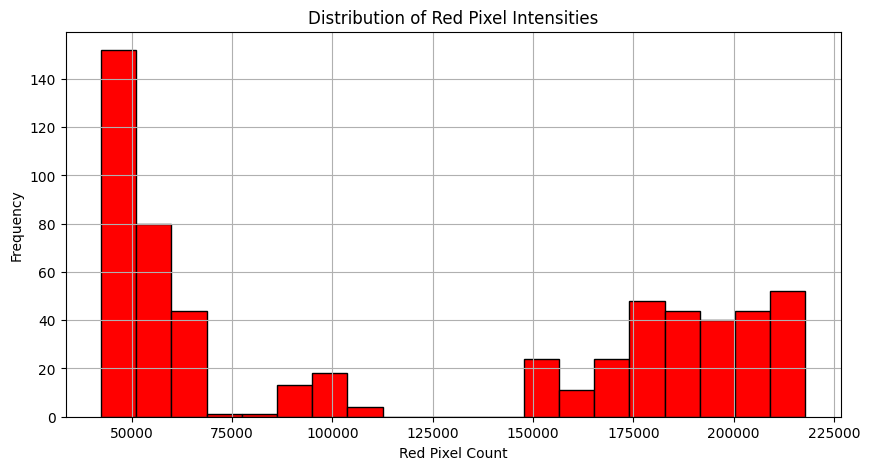

In [20]:
generate_red_alert_summary(
    alert_log,
    input_video_path="Thermal Video/video1.mp4",
    fps=30,
    top_n=10,
    threshold=5000
)


In [21]:
#Step 8: Display a specific frame by frame number
import cv2
import matplotlib.pyplot as plt

def show_frame_from_video(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_number >= total_frames or frame_number < 0:
        print(f"Frame number {frame_number} is out of range. Total frames: {total_frames}")
        cap.release()
        return
    
    # Set video position to desired frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    
    if not ret:
        print(f"Failed to read frame {frame_number}")
        cap.release()
        return
    
    cap.release()
    
    # Convert BGR to RGB for display in matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame Number: {frame_number}")
    plt.axis('off')
    plt.show()


In [22]:
#step 9 : Display a specific frame from the video
# Example: Display frame number 150 from the original video
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def process_top_alert_frames(
    alert_log,
    input_video_path,
    output_video_path,
    save_folder=None,
    top_n=5,
    min_threshold=5000,
    display_inline=True,
    show_cv2=False
):
    if not alert_log:
        print("❌ No alert frames found.")
        return

    # Filter and sort alert frames
    filtered_alerts = [a for a in alert_log if a['red_intensity'] >= min_threshold]
    if not filtered_alerts:
        print(f"❌ No frames with red intensity >= {min_threshold}")
        return

    top_alerts = sorted(filtered_alerts, key=lambda x: x['red_intensity'], reverse=True)[:top_n]

    # Create folder if saving is requested
    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    cap_orig = cv2.VideoCapture(input_video_path)
    cap_proc = cv2.VideoCapture(output_video_path)

    if display_inline:
        fig, axes = plt.subplots(len(top_alerts), 1, figsize=(15, 5 * len(top_alerts)))
        if len(top_alerts) == 1:
            axes = [axes]

    for idx, alert in enumerate(top_alerts):
        frame_num = alert['frame']
        red_intensity = alert['red_intensity']
        timestamp = alert['timestamp_str']

        cap_orig.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        cap_proc.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

        ret_orig, frame_orig = cap_orig.read()
        ret_proc, frame_proc = cap_proc.read()

        if not ret_orig or not ret_proc:
            print(f"❌ Could not read frame {frame_num}")
            continue

        # Resize to match dimensions if needed
        if frame_orig.shape != frame_proc.shape:
            height = min(frame_orig.shape[0], frame_proc.shape[0])
            width = min(frame_orig.shape[1], frame_proc.shape[1])
            frame_orig = cv2.resize(frame_orig, (width, height))
            frame_proc = cv2.resize(frame_proc, (width, height))

        # Add white vertical separator
        separator = 255 * np.ones((frame_orig.shape[0], 10, 3), dtype=np.uint8)
        combined = np.hstack((frame_orig, separator, frame_proc))

        # Overlay text on combined image
        overlay_text = f"Frame: {frame_num} | Time: {timestamp} | Intensity: {red_intensity}"
        cv2.putText(combined, overlay_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 255), 2, cv2.LINE_AA)

        # Save image if required
        if save_folder:
            filename = f"alert_{idx+1}_frame_{frame_num}.jpg"
            path = os.path.join(save_folder, filename)
            cv2.imwrite(path, combined)
            print(f"✅ Saved: {path}")

        # Display using OpenCV GUI
        if show_cv2:
            cv2.imshow(f"Top Alert Frame {idx+1}", combined)
            key = cv2.waitKey(1000)
            if key == ord('q'):
                break
            cv2.destroyWindow(f"Top Alert Frame {idx+1}")

        # Display inline (Jupyter)
        if display_inline:
            combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(combined_rgb)
            axes[idx].axis("off")
            axes[idx].set_title(overlay_text)

    cap_orig.release()
    cap_proc.release()
    if show_cv2:
        cv2.destroyAllWindows()

    if display_inline:
        plt.tight_layout()
        plt.show()




✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_1_frame_597.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_2_frame_598.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_3_frame_599.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_4_frame_596.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_5_frame_593.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_6_frame_594.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_7_frame_595.jpg
✅ Saved: c:\Users\DELL\Desktop\Thermal-Video-Red-Zone-Detection-and-Alerting-System\TopAlertFrames\alert_8_frame_592.jpg
✅ Saved: c:\Users\DELL\Desktop\T

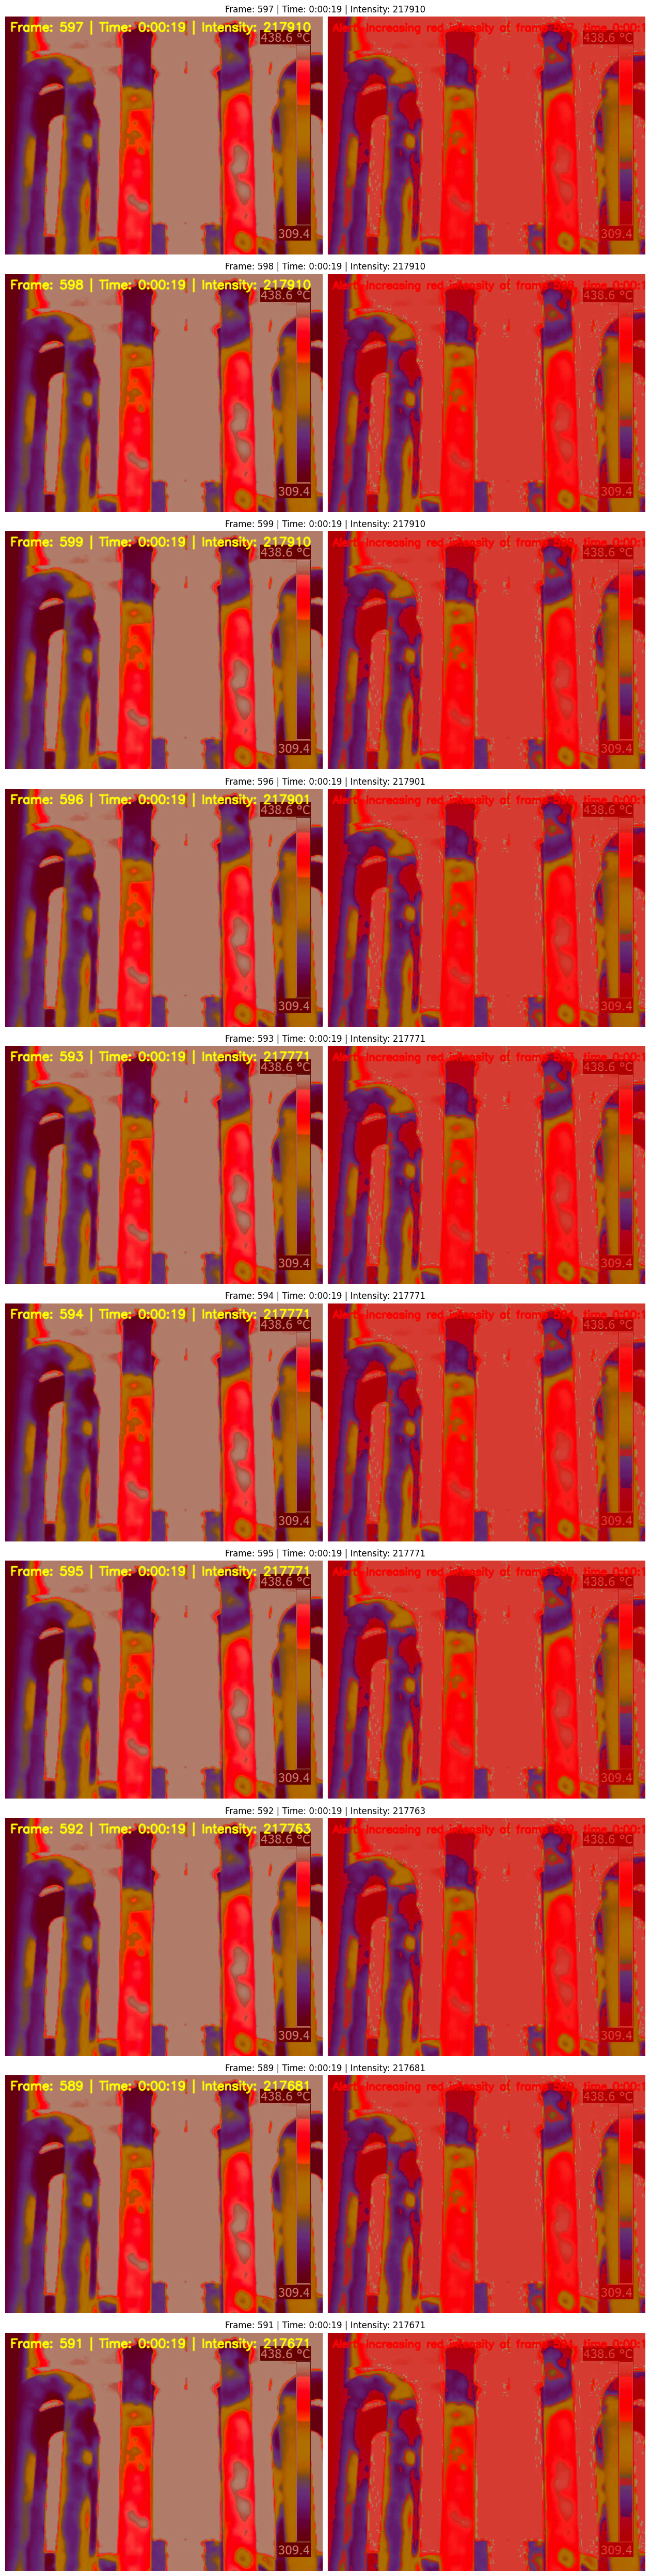

In [23]:
# step 9.1 : Call the function to process and display top alert frames
# Example: Display top 10 alert frames with red intensity >= 5000
import os

save_folder = os.path.abspath("TopAlertFrames")  # This ensures full valid path

process_top_alert_frames(
    alert_log,
    input_video_path="Thermal Video/video1.mp4",
    output_video_path="OutputVideos/video1_red_detection_output.mp4",
    save_folder=save_folder,
    top_n=10,
    min_threshold=5000,
    display_inline=True,
    show_cv2=False
)